In [25]:
"""
Data Scraping: You're already scraping data from a website. You might need to modify the URL or the scraping logic to get data for individual players instead of teams. You can use libraries like BeautifulSoup or Scrapy for more complex scraping tasks.

Data Cleaning: After scraping the data, you'll likely need to clean it up. This might involve handling missing values, converting data types, or renaming columns. Pandas is a great library for this.

Data Analysis: To create projections, you'll need to perform some sort of analysis on the historical data. This could be as simple as calculating average points per game, or as complex as building a machine learning model. Libraries like numpy, pandas, and scikit-learn can help with this.

Data Visualization: You can use matplotlib or seaborn to create visualizations in Jupyter. You might create line graphs of a player's performance over time, bar graphs comparing different players, or heatmaps of player performance by game.

Output to Google Sheets: You can use the gspread library to interact with Google Sheets. You'll need to authenticate with your Google account, which can be done using the oauth2client library.
"""
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import os
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from scipy.stats import zscore


# Constants
COLUMN_ORDER = [
    "Player",
    "Team",
    "Position",
    "GP",
    "D Points",
    "Goals",
    "Total Assists",
    "Shots",
    "Special Teams Points",
    "Hits",
    "Shots Blocked",
    "Takeaways",
    "Faceoffs Won",
    "TOI",
]
NUM_PLAYERS = 300
URL_ALL_STRENGTHS, URL_EVEN_STRENGTH = (
    "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL",
    "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=ev&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL",
)
URL_FBL_FANTRAX = "https://www.fantrax.com/fantasy/league/1papyorqllbhqzl7/players;statusOrTeamFilter=ALL;pageNumber=1"


In [26]:
def load_data(file_path):
    if os.path.exists(file_path) :
        # Get the modification time of the CSV
        modtime = os.path.getmtime(file_path)
        # Get the current time
        current_time = time.time()

        if current_time - modtime < 3600:
            df = pd.read_csv(file_path, index_col=0)
        else:
            df = scrape_data(file_path)
    else:
        df = scrape_data(file_path)

    return df


In [27]:
# Scrape data
def scrape_data(file_path):
    if file_path == "all_strengths.csv":
        url = URL_ALL_STRENGTHS
    elif file_path == "even_strength.csv":
        url = URL_EVEN_STRENGTH

    # Scrape the data
    df = (pd.read_html(url, index_col=0)[0])

    # Save to csv
    df.to_csv(file_path)

    return df


In [28]:
def scrape_fantrax():
    # TODO: Figure out how to scrape Fantrax player data for FBL league
    pass


In [29]:
# Add D and STP column
def add_d_and_stp(df_all, df_even):
    df_all["D Points"] = np.where(df_all["Position"] == "D", df_all["Total Points"], 0)
    df_all["Special Teams Points"] = df_all["Total Points"] - df_even["Total Points"]
    return df_all

In [30]:
# Clean data up and add things we need
def clean_data(all_strengths_d, even_strength):
    # TODO: Add things for cleaning data if needed
    pass


In [31]:
# Analyze data
def analyze_data(df):
    df = df.copy()

    df.index = df.index + 1  # Start index at 1
    categories = [
        "D Points",
        "Goals",
        "Total Assists",
        "Shots",
        "Special Teams Points",
        "Hits",
        "Shots Blocked",
        "Takeaways",
        "Faceoffs Won",
        "TOI",
    ]

    # Calculate z-scores for overall season statistics
    for category in categories:
        df[category] = pd.to_numeric(df[category], errors="coerce")
    filtered_data = df[categories].apply(zscore)
    df["Season Value"] = filtered_data.sum(axis=1)
    season_rankings = df.sort_values("Season Value", ascending=False)

    # Normalize stats by games played
    for category in categories:
        df[category] = df[category] / df["GP"]

    # Calculate z-scores for per game statistics
    filtered_data = df[categories].apply(zscore)
    df["Per Game Value"] = filtered_data.sum(axis=1)
    per_game_rankings = df.sort_values("Per Game Value", ascending=False)

    # Round numbers to 2 decimal places
    df = df.round(2)

    # Select and order columns
    season_rankings = season_rankings.loc[:, ["Season Value"] + COLUMN_ORDER]
    per_game_rankings = per_game_rankings.loc[:, ["Per Game Value"] + COLUMN_ORDER]

    # Add 'Rank' Column
    season_rankings.insert(0, "Rank", range(1, len(season_rankings) + 1))
    per_game_rankings.insert(0, "Rank", range(1, len(season_rankings) + 1))

    return season_rankings, per_game_rankings


In [32]:
def find_value(season_rankings, per_game_rankings):
    # Ensure Player is set as index for both dataframes
    season_rankings.set_index("Player", inplace=True)
    per_game_rankings.set_index("Player", inplace=True)

    # Calculate discrepancy in value
    discrepancy = per_game_rankings["Per Game Value"] - season_rankings["Season Value"]

    # Create a new DataFrame for discrepancy
    discrepancy_df = discrepancy.to_frame(name="Discrepancy")

    # Filter players where Per Game Value is higher than Season Value
    filtered_discrepancy = discrepancy_df[discrepancy_df["Discrepancy"] > 0]

    # sort player by discrepancy
    sorted_discrepancy = filtered_discrepancy.sort_values(
        "Discrepancy", ascending=False
    )

    # Select top 50 players
    top_50_players = sorted_discrepancy.head(50)

    return top_50_players


In [33]:
def format_and_print(df):
    def color_rows(s):
        return [
            "background-color: #44475a" if i % 2 else "background-color: #282a36"
            for i in range(len(s))
        ]

    return df.style.apply(color_rows).hide(axis="index")


In [34]:
# Visualize rankings
def visualize_top_50_discrepancy(season_rankings, per_game_rankings):
    # Get top 50 players by discrepancy
    top_50_players = find_value(season_rankings, per_game_rankings)
    # Sort players by discrepancy in ascending order
    top_50_players = top_50_players.sort_values(by="Discrepancy", ascending=True)

    # Create horizontal bar plot
    plt.figure(figsize=(10, 10))
    bars = plt.barh(top_50_players.index, top_50_players["Discrepancy"])

    # Add discrepancy values at the end of each bar
    for bar in bars:
        xval = bar.get_width()
        plt.text(xval, bar.get_y() + bar.get_height() / 2, round(xval, 2), va="center")

    plt.title("Top 50 Players by Discrepancy")
    plt.xlabel("Discrepancy")
    plt.ylabel("Player")
    plt.show()


In [35]:
# Output to Google Sheets
def output_to_gsheets(df, worksheet_name):
    gc = gspread.oauth()
    sh = gc.open("FantasyStats")
    
    # Get the worksheet or create it if it doesn't exist
    try:
        worksheet = sh.worksheet(worksheet_name)
    except gspread.exceptions.WorksheetNotFound:
        worksheet = sh.add_worksheet(title=worksheet_name, rows="400", cols="25")

    # Clear the worksheet
    worksheet.clear()
    # Convert the index to a column
    df.reset_index(level=0, inplace=True)

    # Reorder the columns
    df = df.reindex(columns=['Rank'] + COLUMN_ORDER)

    # Update the worksheet with the DataFrame data
    worksheet.update(values=[df.columns.values.tolist()] + df.values.tolist(), range_name=None)

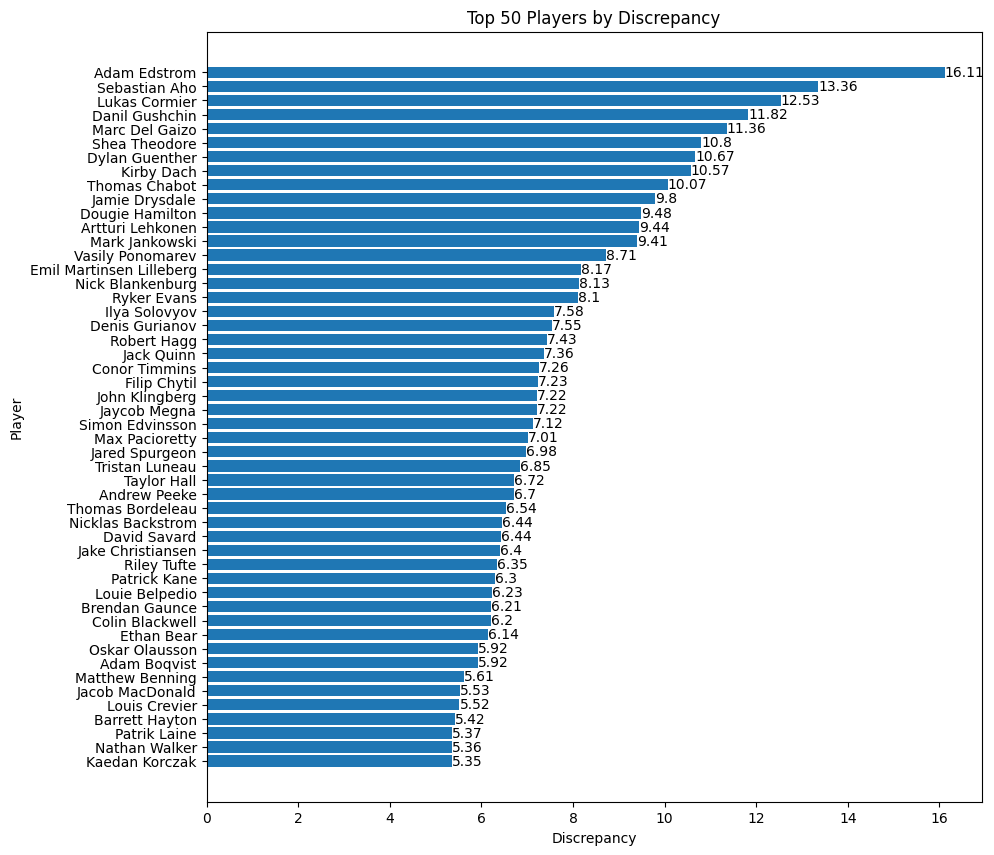

C:\Users\holym\AppData\Local\Temp\ipykernel_26252\1693607175.py:21: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(values=[df.columns.values.tolist()] + df.values.tolist(), range_name=None)
C:\Users\holym\AppData\Local\Temp\ipykernel_26252\1693607175.py:21: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(values=[df.columns.values.tolist()] + df.values.tolist(), range_name=None)


In [36]:
# Main function
def main():
    all_strengths = load_data("all_strengths.csv")
    even_strength = load_data("even_strength.csv")
    all_stats_df = add_d_and_stp(all_strengths, even_strength)
    season_rankings, per_game_rankings = analyze_data(all_stats_df)
    visualize_top_50_discrepancy(season_rankings, per_game_rankings)
    output_to_gsheets(season_rankings, 'Season Rankings')
    output_to_gsheets(per_game_rankings, 'Per Game Rankings')


# Run the main function
if __name__ == "__main__":
    main()
